In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import folium
import numpy as np
import seaborn as sn
from shapely.geometry import Point
from IPython.display import Image
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('ggplot')

In [2]:
# Connect to Oracle
eng = nivapy.da.connect()

Connection successful.


# MARTINI - identify river input datasets

The marine models used in MARTINI require terrestrial inputs from the major rivers draining to Skagerrak. This notebook explores various different river chemistry datasets to see what's available.

Requirements for the data have been outlined by Phil (see e-mail received 19.09.2018 at 20.14):

 * Annual, monthly and daily nutrient concentrations in $mmol/m^3$. We are mostly interested in daily values, but monthly or even annual estimates could be used initially
 
 * The time period of interest is 2015 to 2017
 
 * For nitrogen: $NO_3$, $NH_4$, $DON$ and $PON$. $TOTN$ is not used directly in the marine models but would nevertheless be useful
 
 * For phosphorus: $PO_4$, $DOP$ and $POP$. As with N, $TOTP$ is not used directly, but will be useful
 
 * $DOC$/$TOC$, plus any other data on organic carbon 
 
 * Any spectral data relating to $CDOM$ e.g. UV absorbance or spectral slope
 
 * Daily flows in $m^3/s$ (**already done by Andre**)
 
## 1. Rivers of interest

The rivers of interest are listed by Andre (see e-mail received 09.11.2018 at 15.15). Andre already has daily flow values for these locations, so the main aim here to is identify as much compatible water chemistry as possible. We need data from Norway, Sweden and Denmark:

 * **Norway**. Data for 25 major rivers (vassdragområder 001 to 025)
 
 * **Sweden**. Data for 5 major rivers (IDs 108 to 112 from SMHI's [Vattenwebb](https://www.smhi.se/klimatdata/hydrologi/vattenwebb))
 
 * **Denmark**. Data for 9 rivers. Currently not sure where to find this, but have e-mailed Ciaran for suggestions
 
Andre's list of rivers is shown below. Note that he has divided some river outflows into two parts (because they connect to different cells in the marine model). There are therefore 42 rivers in the list, but we only need to identify chemistry data for **39 distinct rivers**.

In [3]:
# Read Andre's list of rivers
riv_xlsx = r'../../../andre_river_data/andre_martini_rivers_jes.xlsx'
riv_df = pd.read_excel(riv_xlsx, sheet_name='rivers')

riv_df

,martini_id,station_name,resa_id,vannmiljo_id,lat,lon,martini_code
0,34,Vigsø bukt,NaN,NaN,57.0998,8.7573,dmca003
1,35,West side of Nord-Jylland - Liver Å,NaN,NaN,57.5330,9.8866,dmca004
2,36,Hirtshals-Skagen - Uggerby Å,NaN,NaN,57.5922,10.1498,dmca005
3,37,Skagen- Lyngsaa strand,NaN,NaN,57.5922,10.1498,dmca006
4,38,East side of Nord-Jylland,NaN,NaN,57.6539,10.4793,dmca007
5,39,Limfjord,NaN,NaN,56.9761,10.3320,dmca008
6,40,Mariagerfjord,NaN,NaN,56.7114,10.3531,dmca009
7,41,Gudenå,NaN,NaN,56.6023,10.3463,dmca010
8,42,Læsø,NaN,NaN,57.2817,11.1491,dmca011
9,7,Haldenvassdraget,29830.0,001-38541,59.1187,11.3697,nmca001


## 2. Available water chemistry

### 2.1. Norway

The most relevant Norwegian datasets are likely to be those from the RID/Elveovervåkingprogrammet. It is possible to identify RID stations for 24 of the 25 Norwegian rivers in Andre's list (see the `'resa_id'` column in the table above), but note that many of these stations have not been actively monitored by NIVA since the early 2000s. In some cases, monitoring data has been collected more recently by other organisations and these data are available via the [Vannmiljø website](https://vannmiljo.miljodirektoratet.no/). In principle, all the NIVA data should be available here too, so the easiest option - at least initially - is to download as much as possible from Vannmiljø. Vannmiljø station IDs for the nearest stations with good water chemistry are also listed in the table above.

There are two rivers in Andre's dataset for which **I can't find any useful recent data at all: Sandvikselva (`'ncma008'`) and Sageneelve (`'nmca010'`)**.

**Note:** Vannmiljø does not seem to have a public web API and accessing the data manually is slow/tedious (especially because the amount of data that can be downloaded in one go is limited). However, purely by chance, I think I've discovered a bug in the website that makes it possible to download much larger volumes of data than intended by the developers. For future reference:

 * From the main web page, choose ***Jeg vil > Søk i vannlokaliteter***, then leave all the otpions blank and click ***Søk***. This returns a list of all the stations in the database
 
 * The number of selections from this list is limited but, if you just choose ***Overfør kriterier til vannregistreringsøk*** from the upper panel (not from above the data table), it seems you can access the *entire* Vannmiljø dataset :-)
 
I have narrowed the search to only include N, P and C data (all species) for the period from 01/01/2010 to the present, and then exported *all* the Vannmiljø data for the whole of Norway. This produces a fairly large Excel file, but it's much easier to get everything in a single manual step at the start than to manually download a separate file for each site.

#### 2.1.1. Filter and tidy Vannmiljø data

The code below takes a while to run as the Excel file is large. The results are saved in CSV format at the end, so this cell should not need to be re-run unless the Vannmiljø export is updated.

In [ ]:
## Read Vannmiljø dataset
#vm_xlsx = r'../../../vannmiljo_export/vannmiljo_n_p_c_all.xlsx'
#wc_df = pd.read_excel(vm_xlsx, sheet_name='VannmiljoEksport')
#
## Filter to stns of interest
#vm_stns = list(riv_df['vannmiljo_id'].dropna())
#wc_df = wc_df.query('Vannlokalitet_kode in @vm_stns')
#
## Rename and tidy
#wc_df['vassnr'] = wc_df['Vannlokalitet_kode'].str.split('-').str[0]
#wc_df['utm_zone'] = 33
#wc_df['Tid_provetak'] = pd.to_datetime(wc_df['Tid_provetak'], format='%Y-%m-%d %H:%M:%S')
#wc_df['Verdi'] = wc_df['Verdi'].astype(str).str.replace(',', '.').astype(float)
#wc_df.rename({'Vannlokalitet':'station_name',
#              'Parameter_id':'parameter',
#              'Tid_provetak':'sample_date',
#              'Ovre_dyp':'depth1',
#              'Nedre_dyp':'depth2',
#              'Operator':'flag',
#              'Verdi':'value',
#              'Enhet':'unit',
#              'UTM33 Ost (X)':'easting',
#              'UTM33 Nord (Y)':'northing'},
#             inplace=True, axis=1)
#
## Filter cols
#cols = ['vassnr', 'station_name', 'easting', 'northing', 'utm_zone',
#        'sample_date', 'depth1', 'depth2', 'parameter', 'flag', 
#        'value', 'unit']
#wc_df = wc_df[cols]
#wc_df.reset_index(inplace=True, drop=True)
#
## Convert UTM to dd
#wc_df = nivapy.spatial.utm_to_wgs84_dd(wc_df, 
#                                       east='easting', 
#                                       north='northing', 
#                                       zone='utm_zone')
#
## Filter cols
#cols = ['vassnr', 'station_name', 'lon', 'lat', 'sample_date', 
#        'depth1', 'depth2', 'parameter', 'flag', 'value', 'unit']
#wc_df = wc_df[cols]
#
## Save as csv for faster processing
#vm_csv = r'../../../vannmiljo_export/vannmiljo_n_p_c_martini.csv'
#wc_df.to_csv(vm_csv, index=False, encoding='utf-8')

In [13]:
# Read tidied Vannmiljø data back from csv for speed
vm_csv = r'../../../vannmiljo_export/vannmiljo_n_p_c_martini.csv'
wc_df = pd.read_csv(vm_csv)

# Convert dates ignoring times
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date']).dt.date

wc_df.head()

,vassnr,station_name,lon,lat,sample_date,depth1,depth2,parameter,flag,value,unit
0,11,Lierelva v/Røykenveien,10.28084,59.753235,2012-06-06,NaN,NaN,N-TOT,=,720.0,µg/l N
1,11,Lierelva v/Røykenveien,10.28084,59.753235,2010-09-08,NaN,NaN,N-TOT,=,850.0,µg/l N
2,11,Lierelva v/Røykenveien,10.28084,59.753235,2012-05-30,NaN,NaN,N-TOT,=,760.0,µg/l N
3,11,Lierelva v/Røykenveien,10.28084,59.753235,2014-05-28,NaN,NaN,N-TOT,=,680.0,µg/l N
4,11,Lierelva v/Røykenveien,10.28084,59.753235,2016-05-11,NaN,NaN,N-TOT,=,820.0,µg/l N


#### 2.1.2. Compare water chemistry locations to river outflows

In [14]:
# Get unique stations from Vannmiljø data
nor_chem_df = wc_df[['vassnr', 'station_name', 'lon', 'lat']].drop_duplicates()

# Get Norway outlets from Andre's data
nor_out_df = riv_df.loc[riv_df['martini_code'].str.startswith('n')]

# Setup map
map1 = folium.Map(location=[59, 10.8],
                  zoom_start=7,
                  tiles='Stamen Terrain')

# Create feature groups
fg_q = folium.FeatureGroup(name='River outlets')
fg_wc = folium.FeatureGroup(name='Water chemsitry stations')
fgs = [fg_q, fg_wc]

# Add clickable markers for sites
cols = ['green', 'blue']
for df_idx, df in enumerate([nor_out_df, nor_chem_df]):
    for idx, row in df.iterrows():  
        folium.Marker([row['lat'], row['lon']], 
                      popup=row['station_name'],
                      icon=folium.Icon(color=cols[df_idx])).add_to(fgs[df_idx])
    map1.add_child(fgs[df_idx])

# Turn on layer control
map1.add_child(folium.map.LayerControl())

map1

#### 2.1.3. Tidy/aggregate data

The Vannmiljø data often includes duplicates for specific station-date-parameter combinations. These are **averaged** in the code below. Note the following:

 * There is very little data for `'P-TOT-F'` or `'PON'` (not enough to be useful). I have therefore filtered-out these parameters below
 
 * I have aggregated `'P-PO4-F'`, `'P-PO4'`, `'P-ORTO-F'` and `'P-ORTO'` into a single category named `'SRP'`

In [6]:
# Copy raw data
wc_df2 = wc_df.copy()

# Remove unusual pars with v. limited data
wc_df2 = wc_df2.query('parameter not in ("N-SNOX", "P-TOT-F", "PON")')

# Aggregate soluble P params as SRP
srp_pars = ['P-PO4-F', 'P-PO4', 'P-ORTO-F', 'P-ORTO']
wc_df2['parameter'] = np.where(wc_df2['parameter'].isin(srp_pars), 'SRP', wc_df2['parameter'])

# Merge cols
wc_df2['par_unit'] = wc_df2['parameter'] + '_' + wc_df2['unit']
del wc_df2['depth1'], wc_df2['depth2'], wc_df2['parameter']
del wc_df2['flag'], wc_df2['unit']

# Average duplicates
idx_cols = ['vassnr', 'station_name', 'lon', 'lat', 'sample_date', 'par_unit']
wc_df2 = wc_df2.groupby(idx_cols).mean().reset_index()
wc_df2.head()

,vassnr,station_name,lon,lat,sample_date,par_unit,value
0,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2010-01-26,N-TOT_µg/l N,800.0
1,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2010-01-26,P-TOT_µg/l P,19.0
2,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2010-01-26,TOC_mg/l C,9.1
3,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2010-02-08,N-NH4_µg/l N,3.0
4,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2010-02-08,N-NO3_µg/l N,485.0


#### 2.1.4. Plot raw time series

The code below creates a matrix plot showing the raw raw data available at each location. The resulting plots are available [here](https://github.com/JamesSample/martini/tree/master/plots/raw_data) and an example is shown below.

In [7]:
# Plots of raw data
for vass in wc_df2['vassnr'].unique():
    # Get stn data
    df = wc_df2.query('vassnr == @vass')
    
    # Restructure
    df = df.sort_values(['sample_date', 'par_unit'])
    df.set_index(idx_cols, inplace=True)
    df = df.unstack('par_unit').reset_index().sort_values('sample_date')
    df.index = df['sample_date']
    del df['vassnr'], df['station_name'], df['lon'], df['lat'], df['sample_date']
    df.columns = df.columns.get_level_values(1)
    
    # Plot
    df.plot(subplots=True, 
            layout=(2,4), 
            figsize=(15,6), 
            marker='o',
            title=list(df.columns),
            legend=False)
    
    plt.tight_layout()
    
    # Save png
    png_path = r'../plots/raw_data/vassnr_%03d.png' % vass
    plt.savefig(png_path, dpi=300)
    plt.close()    

Raw data for vassdragområde 25.


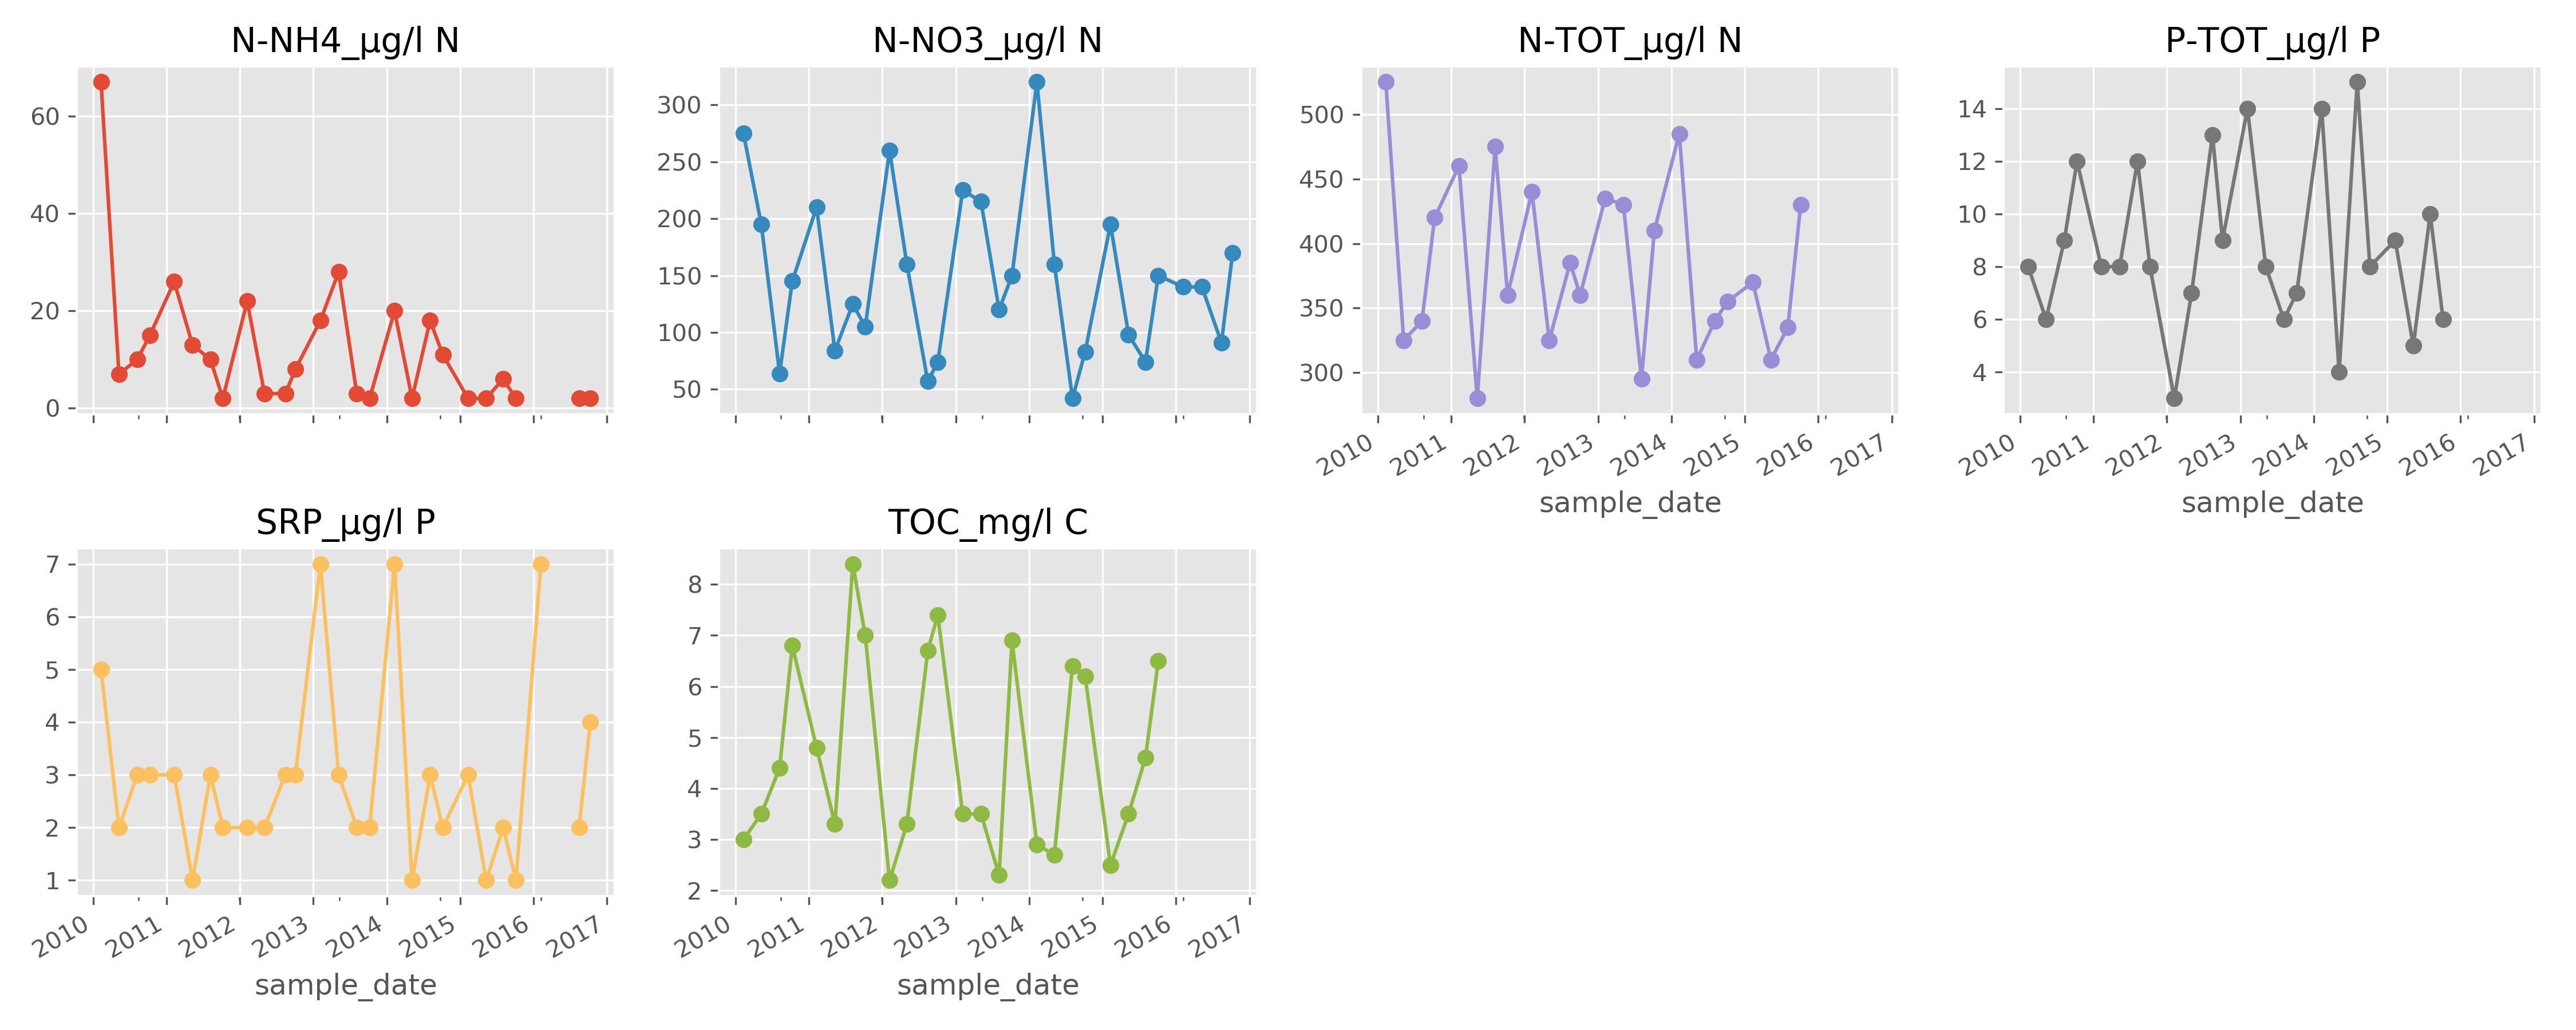

In [8]:
# Show example image
print ('Raw data for vassdragområde %s.' % vass)
Image(png_path)

#### 2.1.5. Simple linear regression against flow

Ultimately, we would like to generate daily resolution time series for the marine models. We have daily flow data for all sites, so one possible option is to consider concentration-discharge plots to see if a relationship existis for predicting concentrations from discharge. In general, such relationships are not straightforward, so I don't expect this to be very successful, but it's worth a go initially. The usual approach is to consider simple OLS regression of $log(C)$ versus $log(Q)$.

The code below creates one matrix plot for each site. The plots are available [here](https://github.com/JamesSample/martini/tree/master/plots/flow_conc_reg) and an example is shown below.

In [10]:
# Simple OLS regression against flow
for vass in wc_df2['vassnr'].unique():
    # Get stn data
    df = wc_df2.query('vassnr == @vass')
    
    # Get RESA stn ID
    mar_cd = 'nmca%03d' % vass
    resa_id = riv_df.query('martini_code == @mar_cd')['resa_id'].iloc[0]
    
    # Get flow data from NIVABASE
    q_df = nivapy.da.extract_resa_discharge(resa_id,
                                            '2010-01-01',
                                            '2017-12-31',
                                            eng,
                                            plot=False)
    
    # Restructure chem
    df = df.sort_values(['sample_date', 'par_unit'])
    df.set_index(idx_cols, inplace=True)
    df = df.unstack('par_unit').reset_index().sort_values('sample_date')
    df.index = df['sample_date']
    del df['vassnr'], df['station_name'], df['lon'], df['lat'], df['sample_date']
    df.columns = df.columns.get_level_values(1)
    
    # Get list of chem cols
    chem_cols = df.columns
    
    # Join to Q
    df = df.join(q_df, how='left')

    # Setup plot
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,6))
    axes = axes.flatten()
    
    # Regression plots for each parameter
    for idx, col in enumerate(chem_cols):
        # Regression plot
        sn.regplot(x=np.log10(df['flow_m3/s']), 
                   y=np.log10(df[col]), 
                   data=df, 
                   ax=axes[idx])
        axes[idx].set_title(col)
        axes[idx].set_xlabel('log[Flow ($m^3/s$)]')
        axes[idx].set_ylabel('log[%s]' % col)
        
    plt.tight_layout()       

    # Save png
    png_path = r'../plots/flow_conc_reg/vassnr_%03d.png' % vass
    plt.savefig(png_path, dpi=300)
    plt.close()  

Regression plots for vassdragområde 25.


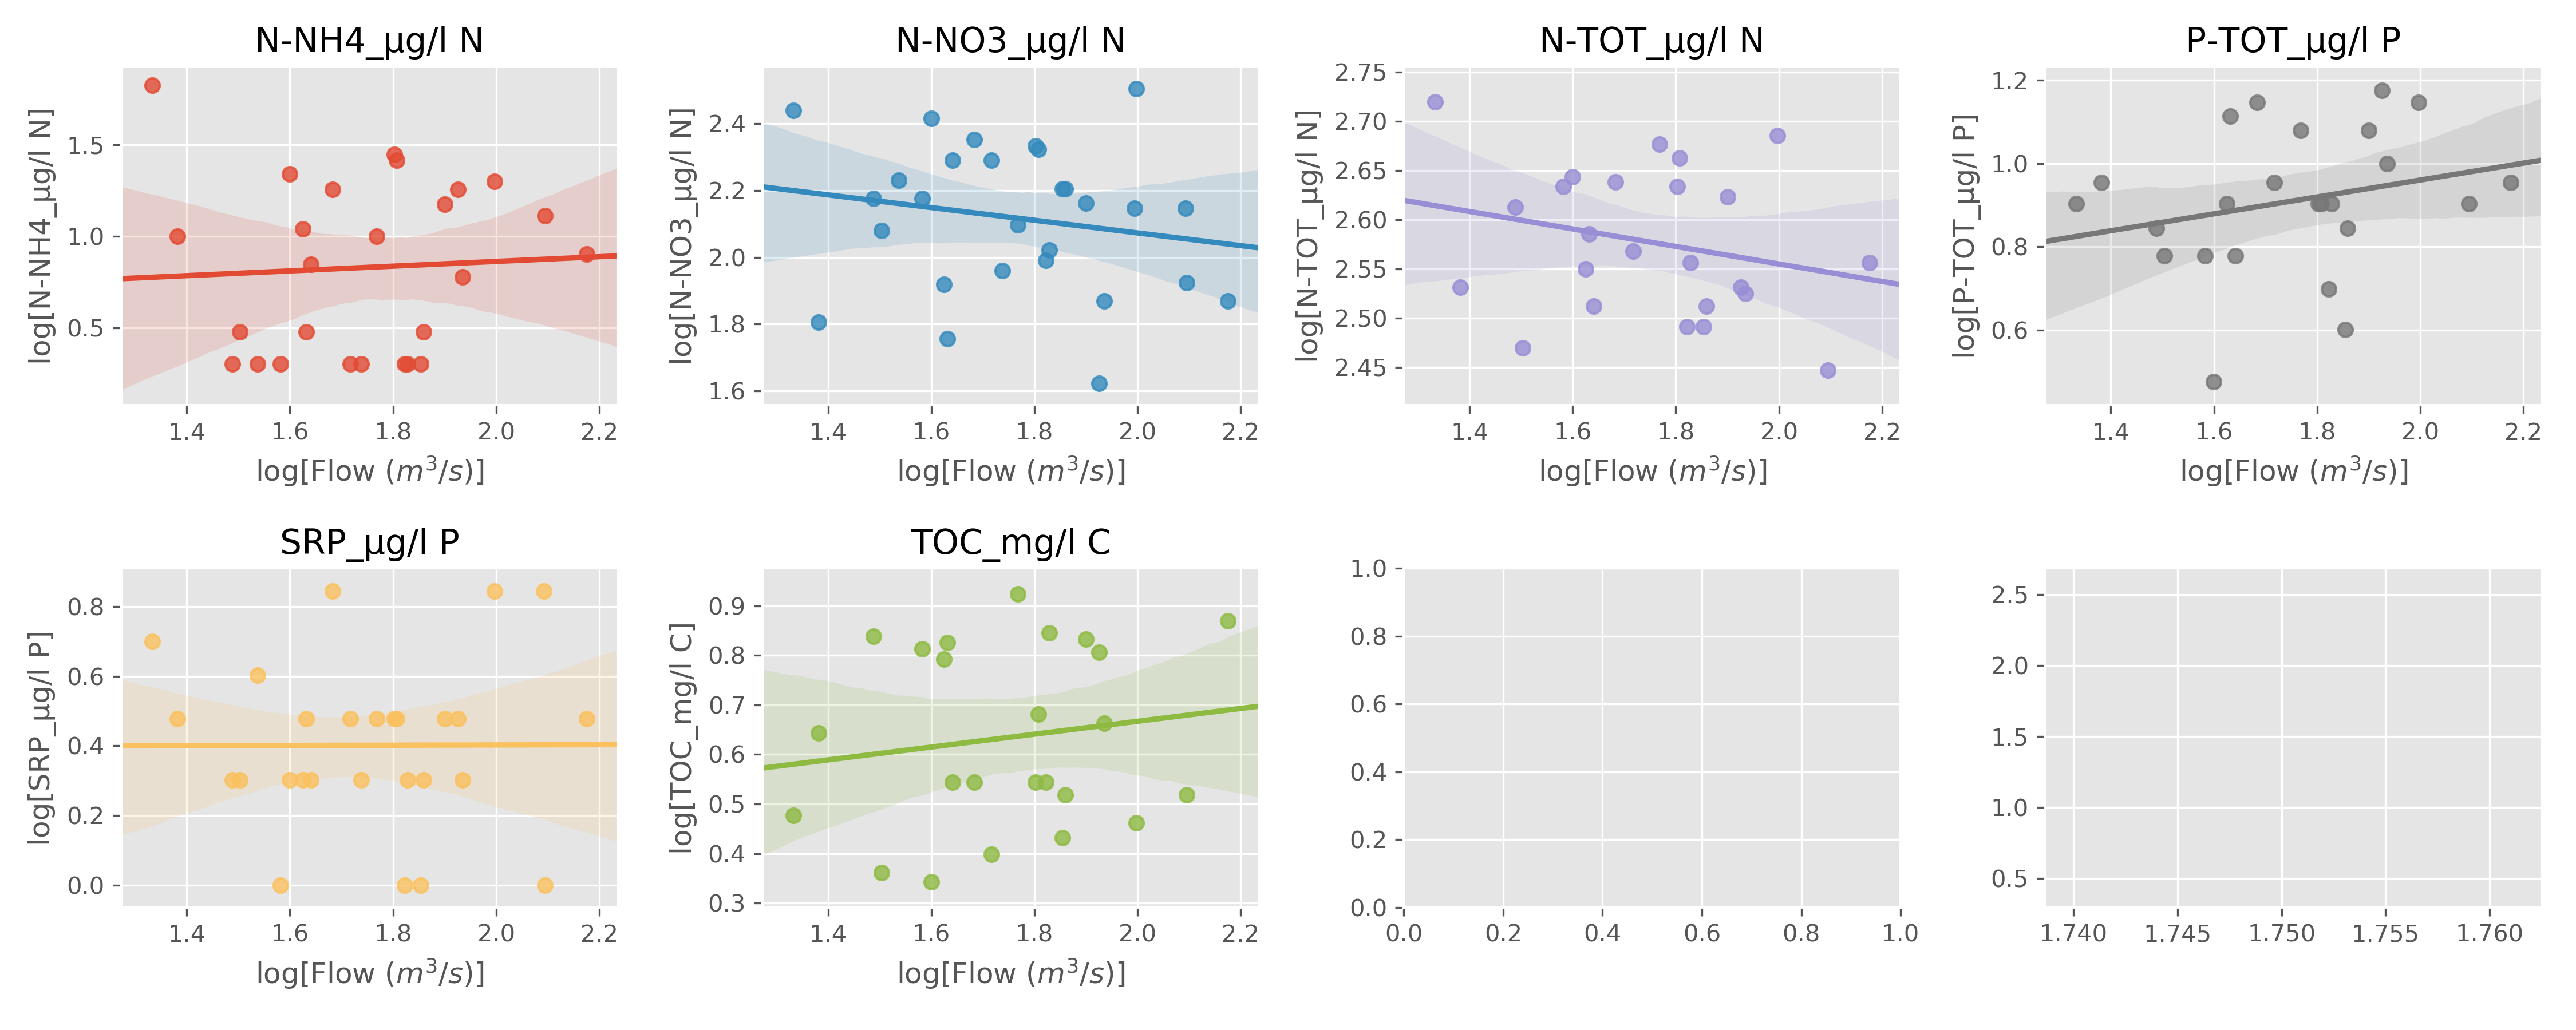

In [11]:
# Show example image
print ('Regression plots for vassdragområde %s.' % vass)
Image(png_path)

The regression results are not very convincing, except in one or two cases for particular parameters at particular sites. I don't think it's appropriate to use these relationships for estimating daily flows, so for now I'll concentrate on providing monthly average concentrations.

#### 2.1.6. "Classical" seasonal decomposition

In some cases, it may be possible to "decompose" the chemistry data into three components: a long-term trend, a monthly cycle and a residual. If this can be done successfully, I can generate monthly datasets as follows:

 1. Calculate monthly averages for the months with data
 
 2. Linearly *interpolate* to estimate values between months with data
 
 3. Extrapolate beyond the available data using the trend and seasonal components
 
The (very rough) code below tests this idea. As above, one matrix plot is produced per site and the full output is available [here](https://github.com/JamesSample/martini/tree/master/plots/seasonal_decomposition).

In [12]:
# "Classical" seasonal decomp for all params.
for vass in wc_df2['vassnr'].unique():
    # Get stn data
    df = wc_df2.query('vassnr == @vass')

    # Restructure chem
    df = df.sort_values(['sample_date', 'par_unit'])
    df.set_index(idx_cols, inplace=True)
    df = df.unstack('par_unit').reset_index().sort_values('sample_date')
    df.index = df['sample_date']
    del df['vassnr'], df['station_name'], df['lon'], df['lat'], df['sample_date']
    df.columns = df.columns.get_level_values(1)
    
    # Setup plot
    fig, axes = plt.subplots(ncols=len(df.columns), 
                             nrows=4, 
                             sharex=True, 
                             figsize=(18,6))
    
    # Loop over pars
    for idx, par in enumerate(df.columns):
        # Get data
        df2 = df[[par,]].copy()

        # Monthly means, then interpolate to fill missing
        df2.dropna(inplace=True)
        df2 = df2.resample('M').mean()
        df2.interpolate(inplace=True)

        # Decompose. Assume "additive" for now
        if len(df2)>12:
            res = seasonal_decompose(df2[par], model='additive')

            # Plot
            res.observed.plot(color='r', ax=axes[0,idx], legend=False)
            axes[0,idx].set_ylabel('Observed')
            axes[0,idx].set_title(par)

            res.trend.plot(color='r', ax=axes[1,idx], legend=False)
            axes[1,idx].set_ylabel('Trend')

            res.seasonal.plot(color='r', ax=axes[2,idx], legend=False)
            axes[2,idx].set_ylabel('Seasonal')

            res.resid.plot(color='r', ax=axes[3,idx], legend=False)
            axes[3,idx].set_ylabel('Residual')
    fig.autofmt_xdate()
    plt.tight_layout()

    # Save png
    png_path = r'../plots/seasonal_decomposition/vassnr_%03d.png' % vass
    plt.savefig(png_path, dpi=300)
    plt.close()  

Seasonal decomposition plots for vassdragområde 25.


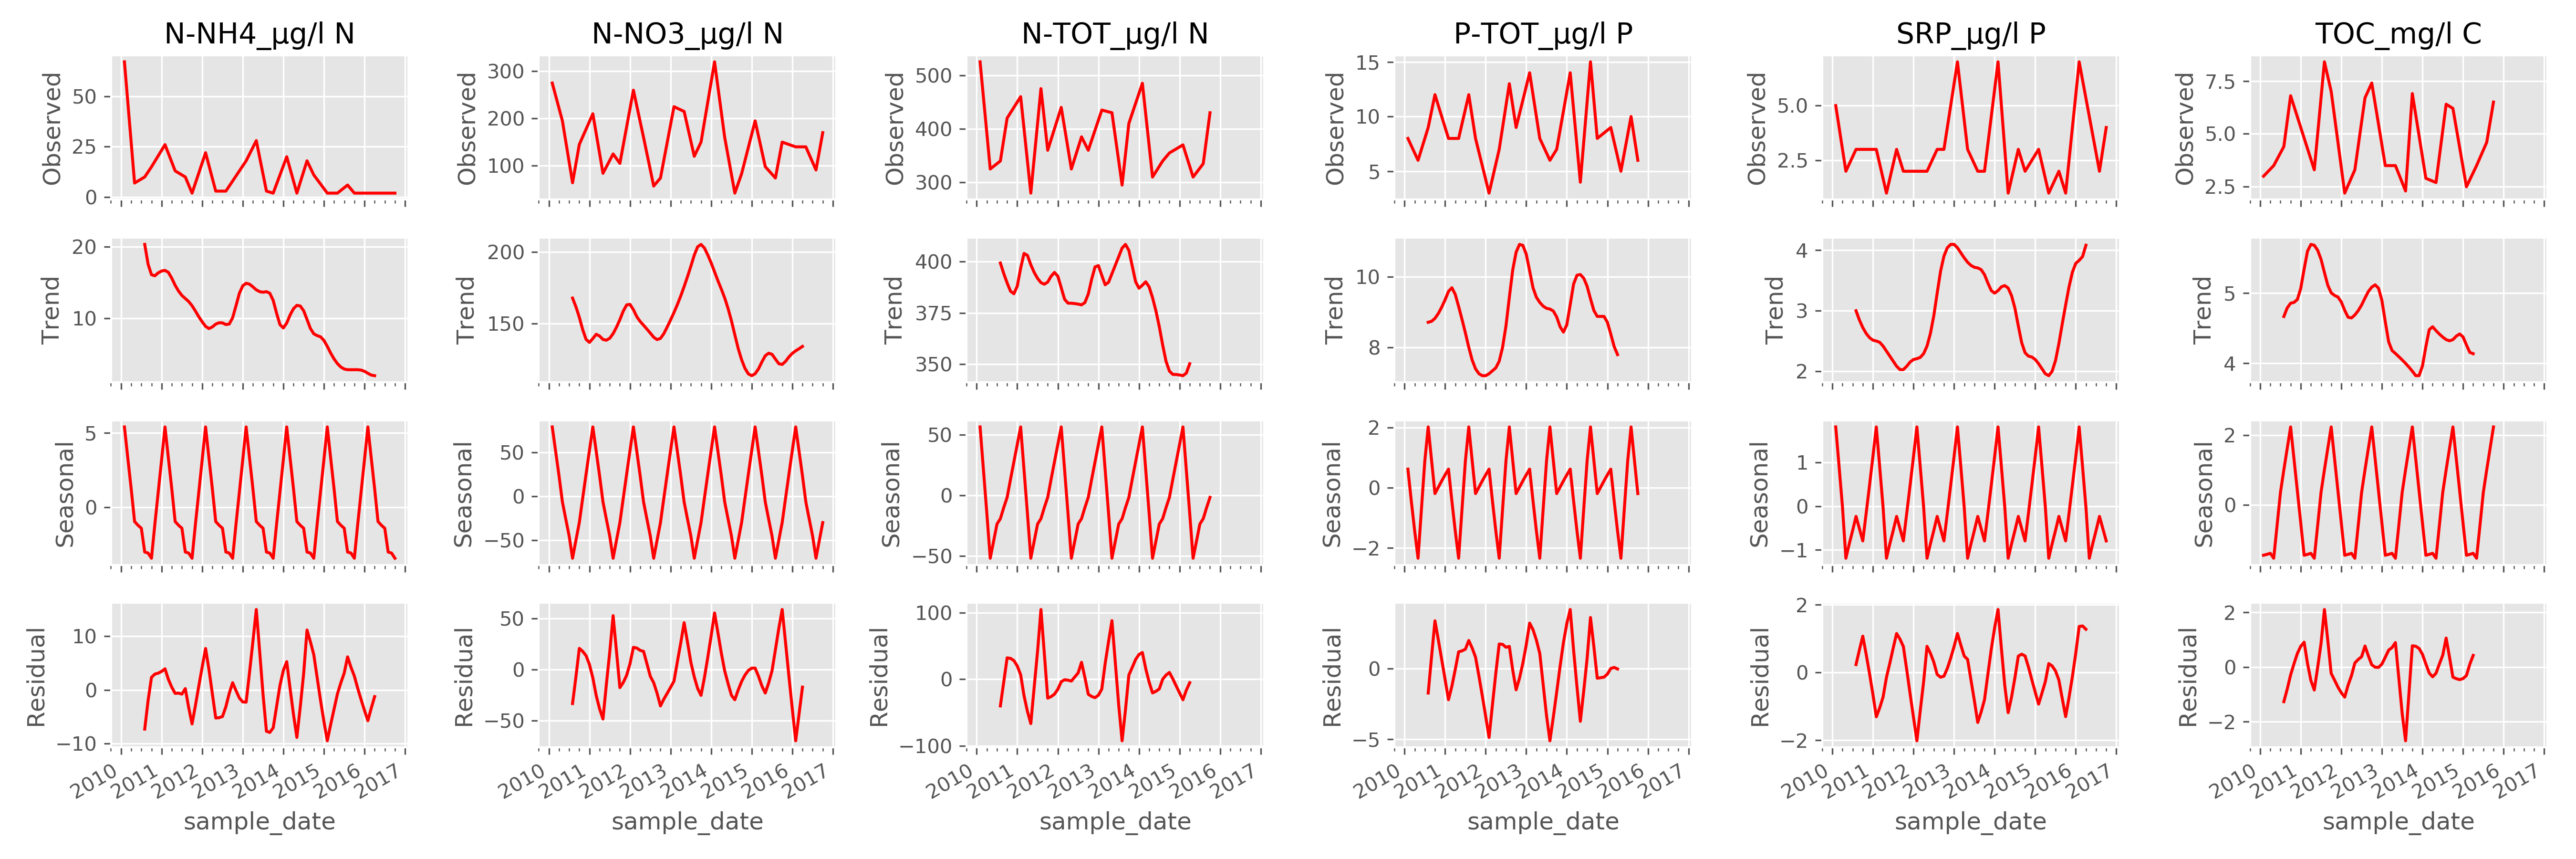

In [15]:
# Show example image
print ('Seasonal decomposition plots for vassdragområde %s.' % vass)
Image(png_path)

Unsurprisingly, the results from seasonal decomposition are not great either: few/no stations exhibit consistent long-term trends and the the residual components are often much larger than the seasonal components, indicating the approach is not successfully partitioning much of the variability. Some of the seasonal patterns do look plausible (e.g. nutrient concentartions declining through the spring and summer, and then building up again during the autumn and winter. However, the magnitude of these variations is generally too small to be used for meaningful data patching.

#### 2.1.7. Fill gaps with long-term monthly means

A poor - but fairly straightforward - strategy is simply to calculate the mean concentrations for each month based on the 2010 to 2018 datasets, and then to assume these concentations are typical for each month without measured data in the period of interest (2015 to 2017). Any remaining NaNs can then be filled by linear interpolation (and back-filling, if necessary). This is not very robust, but it is at least transparent and, given the poor relationships identified so far, probably no worse than the methods explored above.

In [16]:
# Patch with monthly means
for vass in wc_df2['vassnr'].unique():
    # Get stn data
    df = wc_df2.query('vassnr == @vass')

    # Restructure chem
    df = df.sort_values(['sample_date', 'par_unit'])
    df.set_index(idx_cols, inplace=True)
    df = df.unstack('par_unit').reset_index().sort_values('sample_date')
    df.index = df['sample_date']
    del df['vassnr'], df['station_name'], df['lon'], df['lat'], df['sample_date']
    df.columns = df.columns.get_level_values(1)
    
    # Long-term monthly means
    df2 = df.groupby(df.index.month).mean()
    
    # Get series from 2015 to 2017 with monthly avgs. where available
    dates_df = pd.DataFrame(index=pd.date_range(start='2015-01-01',
                                                end='2017-12-31',
                                                freq='M'))
    df.dropna(inplace=True)
    df = df.resample('M').mean()
    df = dates_df.join(df, how='left')
    
    # Iterate over rows filling NaN
    cols = df.columns
    for idx, row in df.iterrows():
        # Get the month for this row
        month = idx.month
        
        # Loop over params.
        for col in cols:
            # If NaN, fill with long-term mean, if available
            if pd.isnull(row[col]):
                try:
                    df.loc[idx][col] = df2.loc[month][col]
                except KeyError:
                    # No data at all for this month between 2010 and 2018
                    # Leave as NaN
                    pass
    
    # Fill remaining NaNs with linear interp.
    df.interpolate(kind='linear', inplace=True)
    
    # Backfill any final NaNs at very start of series
    df.fillna(method='backfill', inplace=True)

    # Plot
    df.plot(subplots=True, 
            layout=(2,4), 
            figsize=(15,6), 
            marker='o',
            title=list(df.columns),
            legend=False)
    
    plt.tight_layout()
    
    # Save png
    png_path = r'../plots/patch_long_term_mean/vassnr_%03d.png' % vass
    plt.savefig(png_path, dpi=300)
    plt.close()  

Patching with long-term monthly averages (plus linear interpolation & back-filling) for vassdragområde 25.


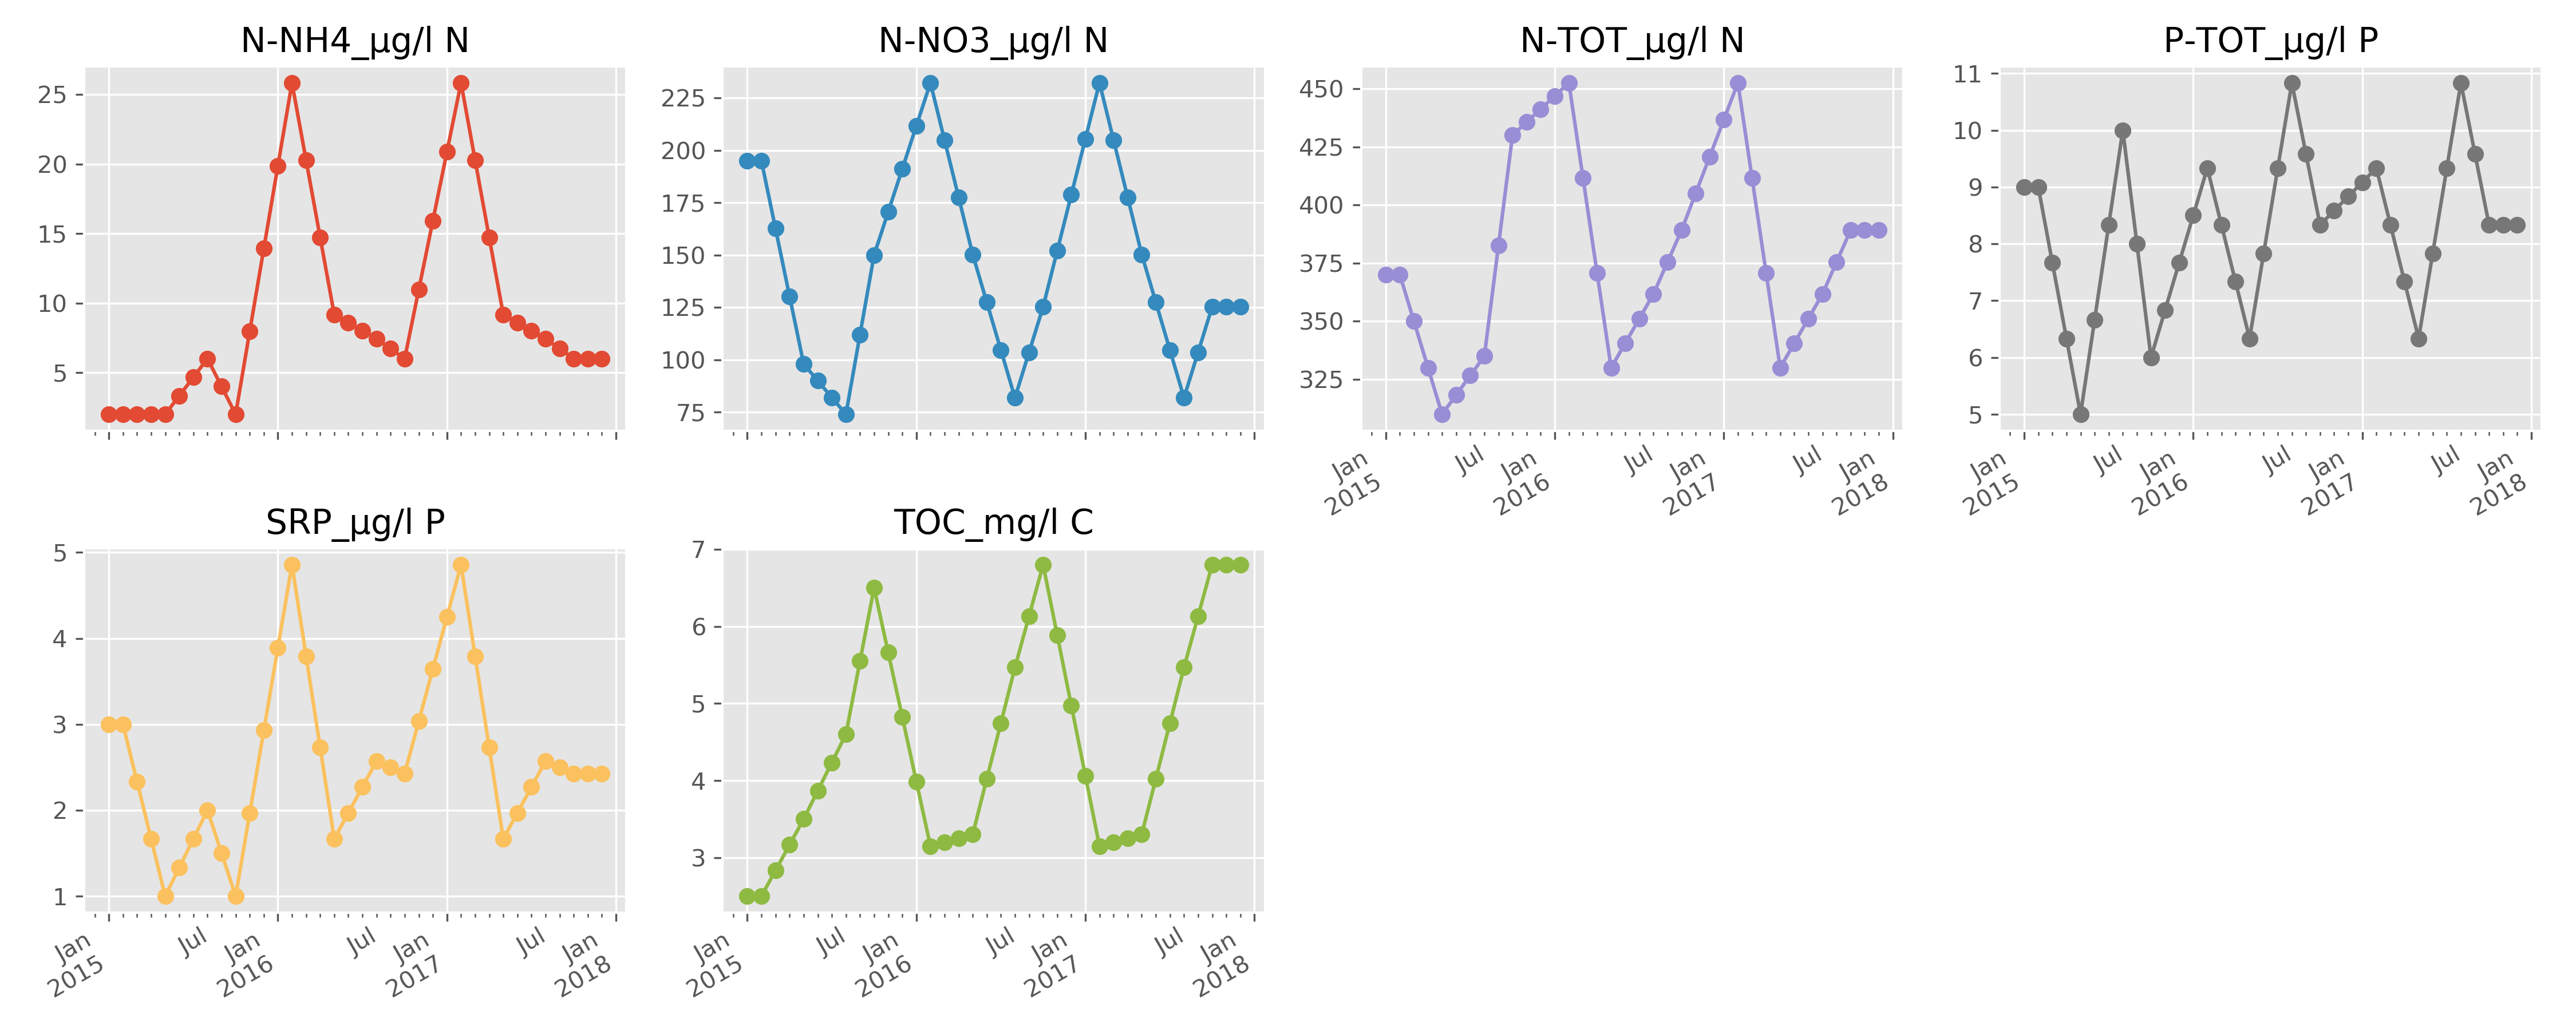

In [17]:
# Show example image
print ('Patching with long-term monthly averages (plus linear interpolation & back-filling) for vassdragområde %s.' % vass)
Image(png_path)

This approach produces a complete monthly series for each variable at each site, but some of these numbers are *very* approximate. **I would be uncomfortable using these datasets for my own modelling work**, but I'm not sure I can produce anything significantly better at this temporal resolution and at the scale of the entire Skagerrak.

#### 2.1.8. Comparison to annual results from NOPE/TEOTIL

As a rough comparison, the code above takes annual fluxes oftoal N and P from [NOPE/TEOTIL](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/nope_model.ipynb) and converts them into flow-weighted annual concentrations for the years 2015, 2016 and 2017. If I then make the (very rough) assumption that these concentrations are constant throughout the year, I can comapre the output to the patched data above. 

(The code below is messy and should be tidied up - it repeats much of what has been done above.)


In [30]:
# Get TEOTIL output
nope_xlsx = r'../../../NOPE/nope_main_catchments_2015-2017.xlsx'

# Loop over worksheets
df_list = []
for year in [2015, 2016, 2017]:
    df = pd.read_excel(nope_xlsx, sheet_name='nope_%s' % year)
    
    # Get just cols for total N & P and flow
    df = df[['regine',
             'accum_all_sources_tot-n_tonnes', 
             'accum_all_sources_tot-p_tonnes', 
             'accum_q_m3/s']]
    df.columns = ['regine', 'tot-n', 'tot-p', 'flow']
    df['year'] = year
    df_list.append(df)
    
# Combine
nope_df = pd.concat(df_list, axis=0)

# Calculate avg. annual concs. (tonnes => ug)
nope_df['tot-n'] = (nope_df['tot-n']*1.E12)/(nope_df['flow']*60*60*24*365*1000)
nope_df['tot-p'] = (nope_df['tot-p']*1.E12)/(nope_df['flow']*60*60*24*365*1000)

# Loop over stations of interest
for vass in wc_df2['vassnr'].unique():
    # Get nope data
    df = nope_df.query('regine == "%03d."' % vass)
    df.index = pd.to_datetime(df['year'], format='%Y')
    del df['year'], df['flow']
    
    # Upcast to monthly
    df = df.resample('M').mean()
    
    # Get series from 2015 to 2017 with monthly dates
    dates_df = pd.DataFrame(index=pd.date_range(start='2015-01-01',
                                                end='2017-12-31',
                                                freq='M'))
    df = dates_df.join(df, how='left')
    df.fillna(method='ffill', inplace=True)   
    ann_df = df.copy()
    
    # Get stn data
    df = wc_df2.query('vassnr == @vass')

    # Restructure chem
    df = df.sort_values(['sample_date', 'par_unit'])
    df.set_index(idx_cols, inplace=True)
    df = df.unstack('par_unit').reset_index().sort_values('sample_date')
    df.index = df['sample_date']
    del df['vassnr'], df['station_name'], df['lon'], df['lat'], df['sample_date']
    df.columns = df.columns.get_level_values(1)
    
    # Get just tot N and P
    try:
        df = df[['N-TOT_µg/l N', 'P-TOT_µg/l P']]

        # Long-term monthly means
        df2 = df.groupby(df.index.month).mean()
        df.dropna(inplace=True)
        df = df.resample('M').mean()
        df = dates_df.join(df, how='left')

        # Iterate over rows filling NaN
        cols = df.columns
        for idx, row in df.iterrows():
            # Get the month for this row
            month = idx.month

            # Loop over params.
            for col in cols:
                # If NaN, fill with long-term mean, if available
                if pd.isnull(row[col]):
                    try:
                        df.loc[idx][col] = df2.loc[month][col]
                    except KeyError:
                        # No data at all for this month between 2010 and 2018
                        # Leave as NaN
                        pass

        # Fill remaining NaNs with linear interp.
        df.interpolate(kind='linear', inplace=True)

        # Backfill any final NaNs at very start of series
        df.fillna(method='backfill', inplace=True)
        mon_df = df.copy()

        # Plot
        fig, axes = plt.subplots(nrows=1, ncols=2,
                                 sharex=True, figsize=(10,6))

        axes[0].plot(mon_df.index, mon_df['N-TOT_µg/l N'], 'ro-', label='Patched monthly')
        axes[0].plot(ann_df.index, ann_df['tot-n'], 'bo-', label='NOPE annual')
        axes[0].set_title('N-TOT_µg/l N')
        axes[0].legend(loc='best')

        axes[1].plot(mon_df.index, mon_df['P-TOT_µg/l P'], 'ro-', label='Patched monthly')
        axes[1].plot(ann_df.index, ann_df['tot-p'], 'bo-', label='NOPE annual')
        axes[1].set_title('P-TOT_µg/l P')
        axes[1].legend(loc='best')
        fig.autofmt_xdate()
        plt.tight_layout()

        # Save png
        png_path = r'../plots/teotil_comparison/vassnr_%03d.png' % vass
        plt.savefig(png_path, dpi=300)
        plt.close()     
    except KeyError:
        print('Station %03d does not have data for both Tot-N and Tot-P. This site will be skipped.' % vass)

Station 005 does not have data for both Tot-N and Tot-P. This site will be skipped.


Comparing the patched monthly data series with flow-weighted annual averages from NOPE/TEOTIL for vassdragområde 25.


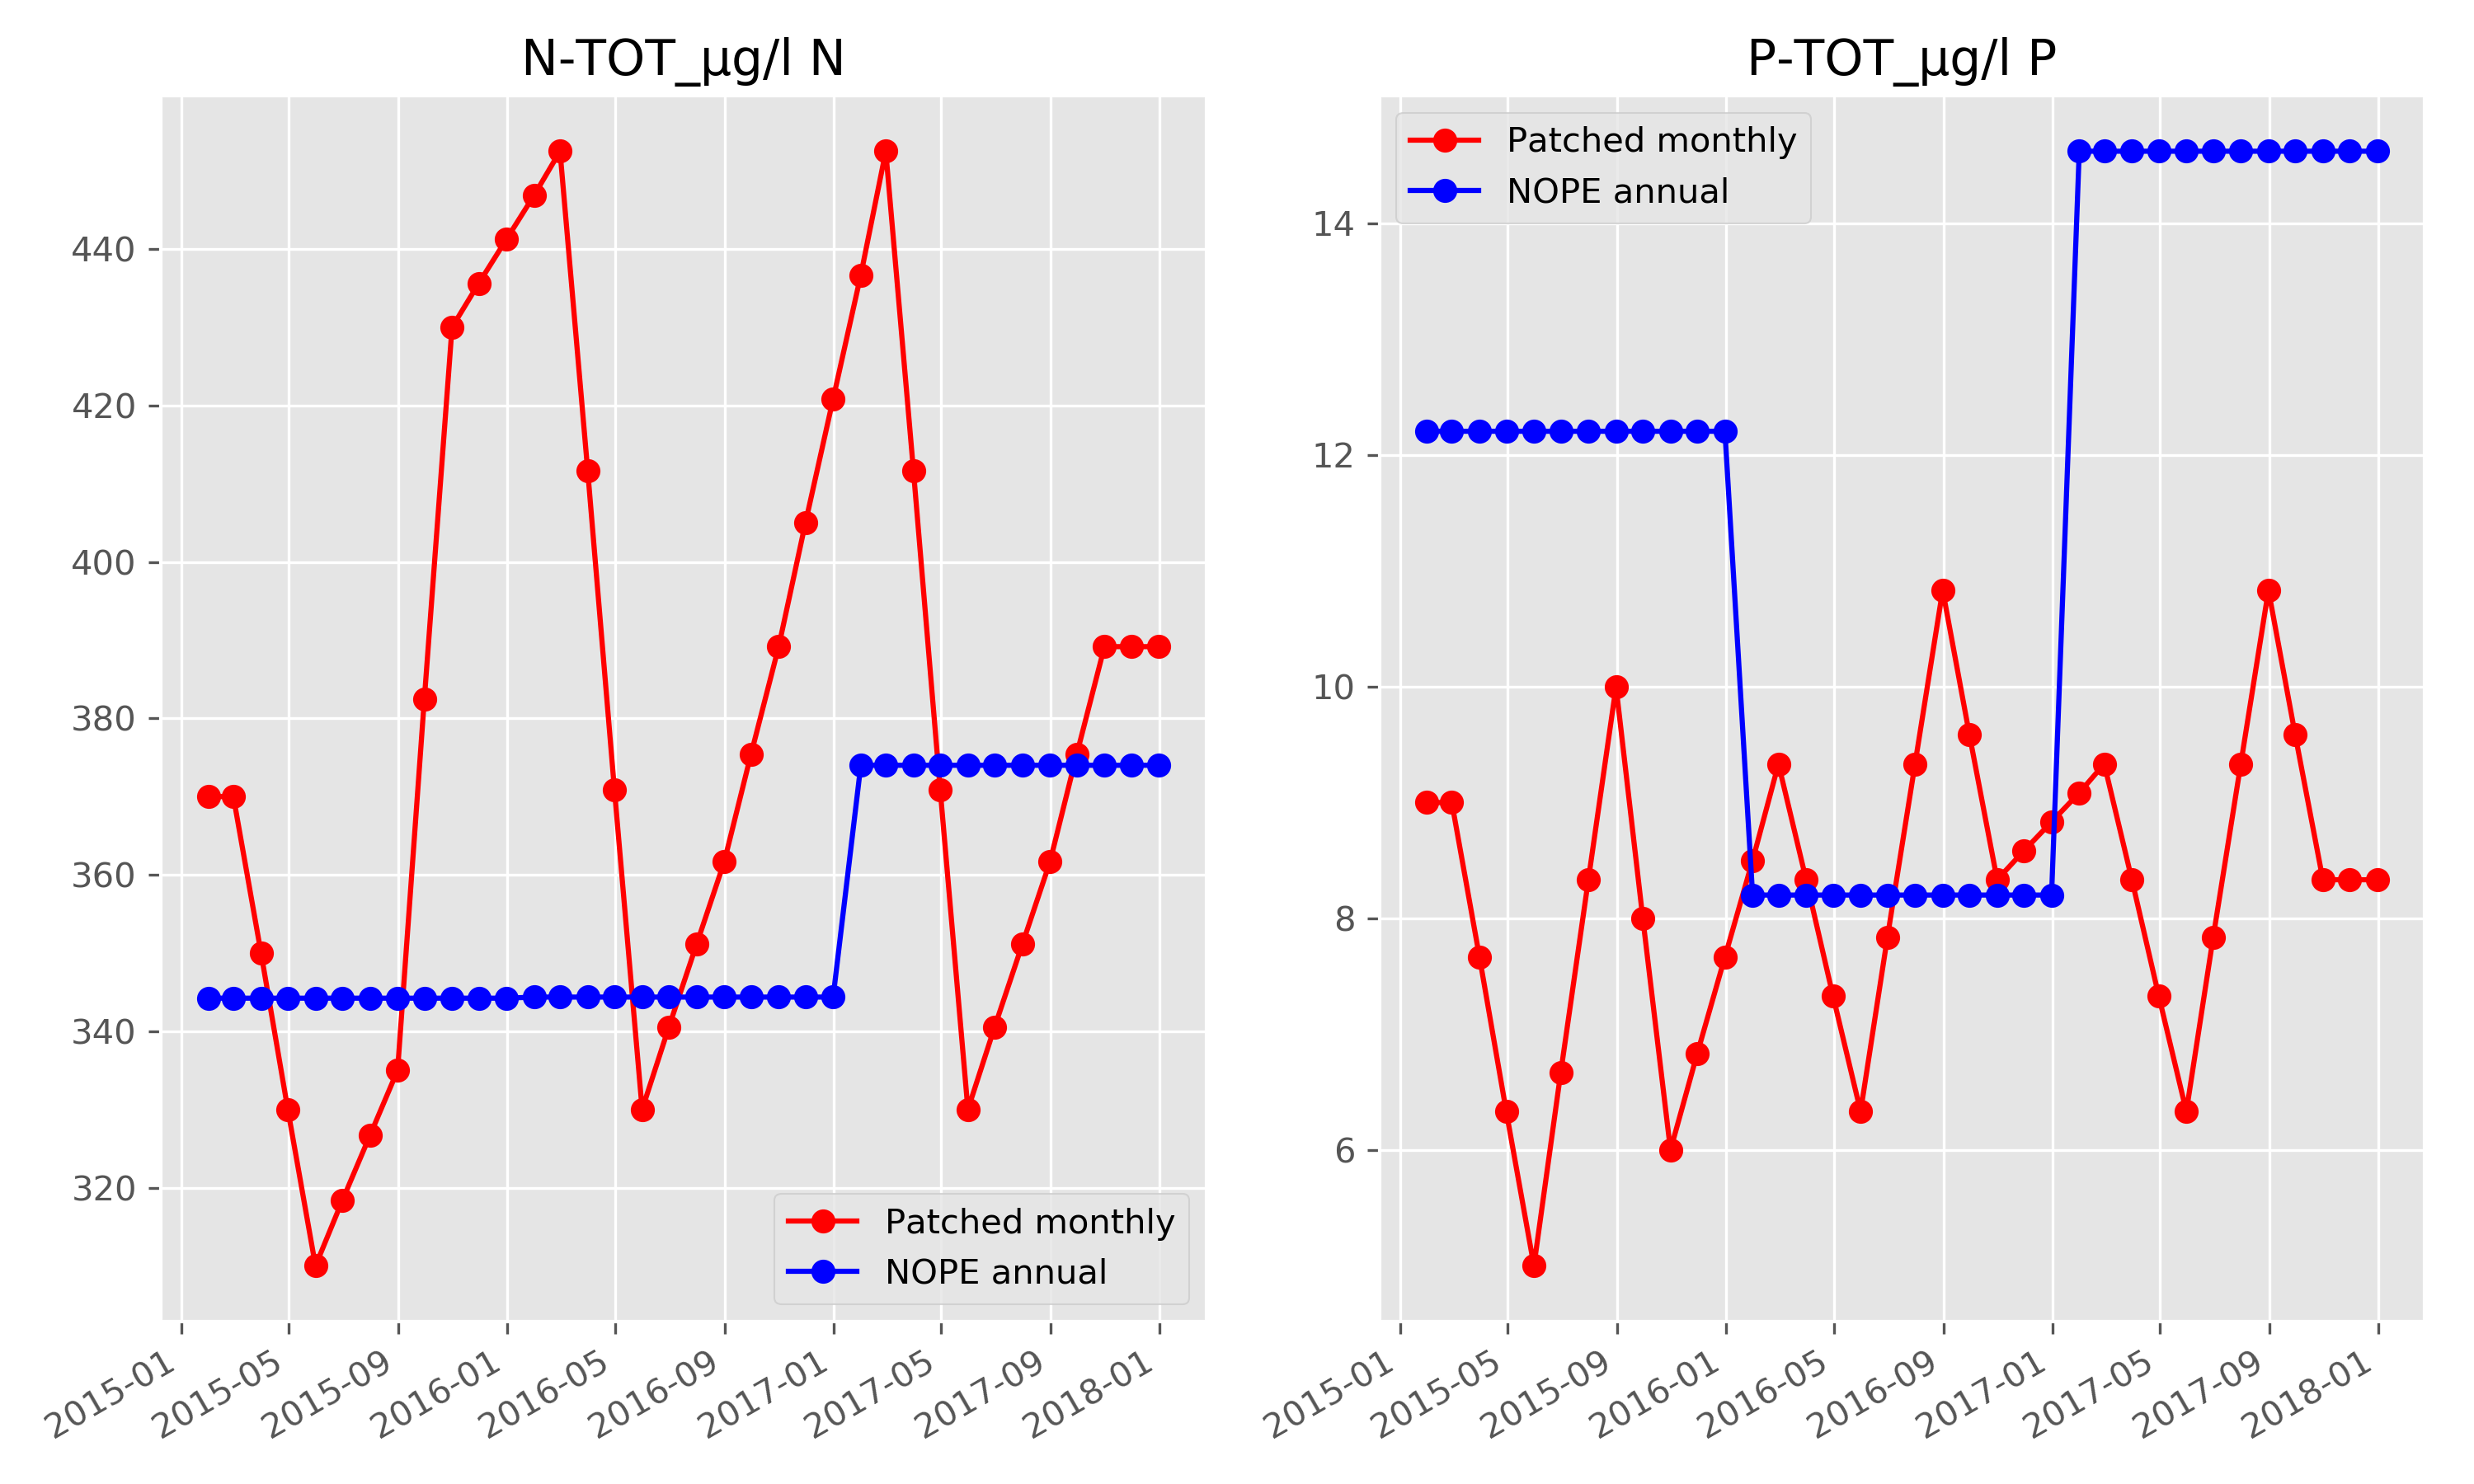

In [34]:
# Show example image
print ('Comparing the patched monthly data series with flow-weighted annual averages from NOPE/TEOTIL for vassdragområde %s.' % vass)
Image(png_path)

# Working/testing

In [ ]:
# Search RESA projects
prj_grid = nivapy.da.select_resa_projects(eng)
prj_grid

In [ ]:
prj_df = prj_grid.get_selected_df()
prj_df

The code below plots Andre's outflow locations in green and the corresponding RID stations in blue. In most cases, the chemistry stations seem fairly well positioned, although there are a few examples where the chemistry station is located some distance upstream.

In [ ]:
# Get RID stations from RESA
stn_df = nivapy.da.select_resa_project_stations(prj_df, eng)

# Filter relevant RID stations for MARTINI
resa_ids = list(riv_df['resa_id'].dropna())
stn_df = stn_df.query('station_id in @resa_ids')

# Setup map
map1 = folium.Map(location=[59, 10.8],
                  zoom_start=7,
                  tiles='Stamen Terrain')

# Create feature groups
fg_q = folium.FeatureGroup(name='Andre flow stations')
fg_wc = folium.FeatureGroup(name='RID water chemsitry stations')
fgs = [fg_q, fg_wc]

# Add clickable markers for sites
cols = ['green', 'blue']
for df_idx, df in enumerate([riv_df, stn_df]):
    for idx, row in df.iterrows():  
        folium.Marker([row['latitude'], row['longitude']], 
                      popup=row['station_name'],
                      icon=folium.Icon(color=cols[df_idx])).add_to(fgs[df_idx])
    map1.add_child(fgs[df_idx])

# Turn on layer control
map1.add_child(folium.map.LayerControl())

map1

In [ ]:
# Define period of interest
st_dt = '2015-01-01'
end_dt = '2017-12-31'

In [ ]:
# Get available parameters for stations in RESA
par_grid = nivapy.da.select_resa_station_parameters(stn_df,
                                                    st_dt,
                                                    end_dt,
                                                    eng)
par_grid

In [ ]:
par_df = par_grid.get_selected_df()
par_df

In [ ]:
# Get data
wc_df, dup_df = nivapy.da.select_resa_water_chemistry(stn_df, 
                                                      par_df, 
                                                      st_dt, 
                                                      end_dt,
                                                      eng, 
                                                      lod_flags=False)
wc_df.head()

The code below produces PNG plot matrices showing the raw data for each RID site between 2015 and 2017.

In [ ]:
# Plots for each site
out_fold = r'../../../rid_raw_chem_plots'

# Loop over sites
for stn_cd in stn_df['station_code']:
    # Setup plot
    fig, axes = plt.subplots(nrows=3, ncols=3, 
                             figsize=(12,8),
                             sharex=True)
    axes = axes.flatten()
    #fig.delaxes(axes[-1])
    
    # Loop over pars
    for idx, par in enumerate(par_df['parameter_name']):
        # Get data
        df = wc_df.query("station_code == @stn_cd")
        df.set_index('sample_date', inplace=True)
        col = [i for i in df.columns if i.split('_')[0]==par]
        df = df[col].dropna(how='any')
        if len(df) > 0:
            df.plot(ax=axes[idx], legend=False, marker='o')
        axes[idx].set_title('%s at %s' % (par, stn_cd))
        axes[idx].set_ylabel(df.columns[0])
    plt.tight_layout()
    
    # Save
    out_png = os.path.join(out_fold, '%s.png' % stn_cd.lower())
    plt.savefig(out_png, dpi=300)
    plt.close()
    
# Display example image
Image(r'../../../rid_raw_chem_plots/østeglo.png')

In [ ]:
# Count samples for each param at each site in period of interest
# Melt to long format
cols = [i for i in wc_df.columns if 
        i.split('_')[0] in list(par_df['parameter_name'])]
cnt_df = wc_df[['station_code']+cols]
cnt_df = cnt_df.melt(id_vars='station_code',
                     var_name='param',
                     value_name='count')

# Aggregate
agg = cnt_df.groupby(['station_code', 'param'])
cnt_df = agg.count().unstack('param')

print ('Data are available for %s out of 25 stations.' % len(cnt_df))
cnt_df

The plot grid above shows the raw data for ØSTEGLO (Glomma), which has one of the best monitoring datasets available. Overall, out of 25 Norwegian stations, the RID programme has the following data for the period from 2015 to 2017:

 * 5 sites with good data ($\geq$ monthly resolution) 
 
 * 7 sites with "OK" data (8 to 9 samples over three years)
 
 * 12 sites with no data in the period from 2015-2017. Most of these sites do have some data from before 2004, butusually only 1 sample per year, which is not very useful here
 
 * 1 site (Sageneelva) with no equivalent in the RID programme
 
In most cases, we have data for the following parameters: $NH_4$, $NO_3$, $TOTN$, $PARTN$, $PO_4$, $TOTP$, $TDP$, $TOC$, $PARTC$.
 
In addition to the monitored data, we also have annual TEOTIL/NOPE flux estimates for all years between 1990 and 2017, but only for $TOTN$ and $TOTP$ (split by various sources).

In [ ]:
# Read Andre's list of rivers
riv_xlsx = r'../../../andre_river_data/andre_martini_rivers_jes.xlsx'
riv_df = pd.read_excel(riv_xlsx, sheet_name='rivers')

# Build geodf
riv_df['geometry'] = riv_df.apply(lambda row: Point(row['lon'], 
                                                    row['lat']), axis=1)
riv_gdf = gpd.GeoDataFrame(riv_df, geometry='geometry')
del riv_gdf['lat'], riv_gdf['lon']
riv_gdf.crs = {'init':'epsg:4326'}

riv_gdf.head()

In [ ]:
# Project to UTM, buffer and project back to WGS84
buffer_dist = 5000  # metres
riv_gdf['geometry'] = riv_gdf.to_crs({'init':'epsg:32633'}).buffer(5000).to_crs({'init':'epsg:4326'})
riv_gdf.head()

In [ ]:
stn_df = nivapy.da.select_resa_stations_in_polygon(riv_gdf, 'martini_id', eng)
stn_df.head()

In [ ]:
nivapy.spatial.plot_polygons_overlay_points?#(stn_df, popup='station_name')

In [ ]:
nivapy.spatial.plot_polygons_overlay_points??